# Overriding root-finding in the generated C++ code -- Chemical kinetics
This is an advanced notebook exploring how the user can override the root-finding routine in the native C++ code which is exported.

If you only want to do some simple modelling of chemical kinetics you may want look into [ChemPy](https://github.io/bjodah/chempy) or [Cantera](http://www.cantera.org/docs/sphinx/html/index.html) (Cantera is more advanced and is the preferred choice when extensive thermodynamic data is available for the reacting species).

In [1]:
from operator import mul
from functools import reduce
import subprocess
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from pyodesys.results import Result
from pyodesys.symbolic import SymbolicSys
from pyodesys.native import native_sys
from pyodesys.native.util import parse_standalone_output
from _chem_kinet import get_odesys
sp.init_printing()
%matplotlib inline

In [2]:
# Fe+3 + SCN- <-> FeSCN+2
stoich_reac, stoich_prod = [(1, 1, 0), (0, 0, 1)], [(0, 0, 1), (1, 1, 0)]
kineticsys = get_odesys(stoich_reac, stoich_prod, 'Fe+3 SCN- FeSCN+2'.split(), SymbolicSys,
                        steady_state_root=True, latex_names=['%s' % s for s in 'Fe^{3+} SCN^- FeSCN^{2+}'.split()])

In [3]:
def integrate_and_plot(odesys, plot=True, **kwargs):
    tend = 2
    result = odesys.integrate(tend, [1e-2, 2e-3, 0], [800, 8], integrator='cvode', **kwargs)
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(14, 4))
        if result.xout[-1] != tend:
            axes[0].axvline(result.xout[-1], linestyle='--', label='t = %.4f' % result.xout[-1])
        result.plot(ax=axes[0])
        result.plot(ax=axes[1], deriv=True)
        axes[1].set_yscale('symlog', linthreshy=1e-9)
        axes[1].axhline(1e-9, linestyle='--')
        axes[1].axhline(-1e-9, linestyle='--')
        for ax in axes:
            ax.set_xlim([0, tend])
    return result

/mount/.local/lib/python2.7/site-packages/numpy/__init__.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  """


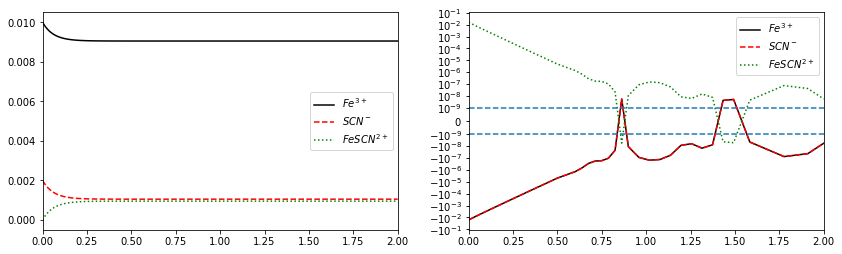

In [4]:
integrate_and_plot(kineticsys)

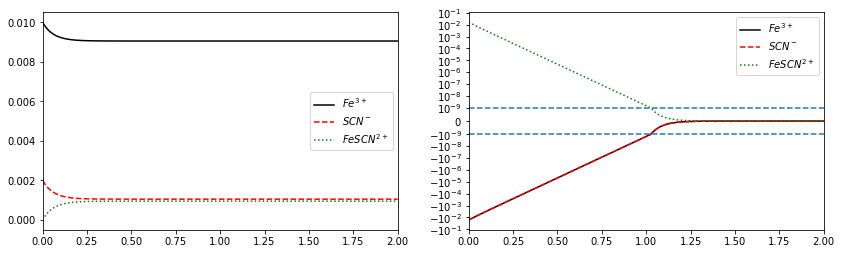

In [5]:
integrate_and_plot(kineticsys, atol=1e-14, rtol=1e-14)

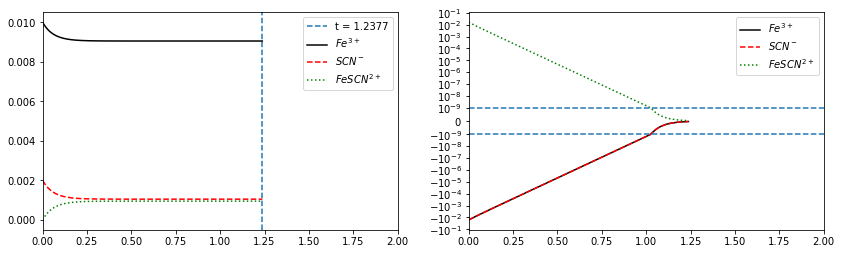

In [6]:
integrate_and_plot(kineticsys, atol=1e-14, rtol=1e-14, return_on_root=True)

In [7]:
kineticsys.roots

In [9]:
native_override = {
    'p_nroots': """ return 1; """,
    'p_roots': """
    const int ny = get_ny();
    std::vector<double> f(ny);
    double tot=0.0;
    rhs(x, y, &f[0]);
    for (int i=0; i<ny; ++i){
        tot += std::min(std::abs(f[i]/m_atol[i]), std::abs(f[i]/y[i]/m_rtol));
    }
    out[0] = tot/ny - m_special_settings[0];
    this->nrev++;
    return AnyODE::Status::success;
"""
}
native_extend={
    'p_constructor': [
        'if (special_settings.size() != 1) std::cerr << "len(special_settings) != 1" << std::endl;'
    ]
}
nativesys = native_sys['cvode'].from_other(
    kineticsys, namespace_override=native_override, namespace_extend=native_extend)
for path in nativesys._native._written_files:
    if path.endswith('.cpp'):
        print(path)
        print('...\n' + ''.join(open(path).readlines()[-20:]))
        print("")

/tmp/tmpfmlmFV_pycodeexport_pyodesys_NativeCvodeCode/odesys_anyode.cpp
...

double OdeSys::get_dx_max(double x, const double * const y) {
    AnyODE::ignore(x); AnyODE::ignore(y);  // avoid compiler warning about unused parameter.
    return INFINITY;
}

AnyODE::Status OdeSys::roots(double x, const double * const y, double * const out) {
    
    const int ny = get_ny();
    std::vector<double> f(ny);
    double tot=0.0;
    rhs(x, y, &f[0]);
    for (int i=0; i<ny; ++i){
        tot += std::min(std::abs(f[i]/m_atol[i]), std::abs(f[i]/y[i]/m_rtol));
    }
    out[0] = tot/ny - m_special_settings[0];
    this->nrev++;
    return AnyODE::Status::success;

}




There are some linking issues with boost's program options in the below (commented) cells.

In [10]:
#standalone_prog = nativesys.as_standalone('chem_kinet', compile_kwargs=dict(options=['warn', 'pic', 'openmp', 'debug']))
#standalone_prog

In [11]:
#p = subprocess.Popen([standalone_prog, '--return-on-root', '1', '--special-settings', '1000'],
#                     stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#out, err = p.communicate(input='2 1e-2 2e-3 0 800 8 0 0 0 0 1'.encode('utf-8'))
#retc = p.wait()
#assert retc == 0
#print(err.decode('utf-8'))

In [12]:
#res_sa, = [Result(*args, kineticsys) for args in parse_standalone_output(out.decode('utf-8').split('\n'))]
#res_sa.plot()

## Time to reach steady state
If we define steady state to occur when the change in chemical concentrations is below a certain threshold, then the obtained time will depend on that threshold. Here we investigate how that choice affects the answer (with respect to numerical precision etc.)

In [13]:
native = native_sys['cvode'].from_other(kineticsys, namespace_override=native_override)

In [14]:
def plot_tss_conv(factor, tols, ax):
    tol_kw = dict(plot=False, return_on_root=True, nsteps=2000, special_settings=[factor])
    tss = [integrate_and_plot(native, atol=tol, rtol=tol, **tol_kw).xout[-1] for tol in tols]
    ax.semilogx(tols, tss, label=factor)

INFO:pyodesys.native._base:In "/tmp/tmpXxGVTE_pycodeexport_pyodesys_NativeCvodeCode", executing:
"/usr/bin/g++ -c -std=c++14 -Wall -Wextra -fPIC -O2 -ffast-math -funroll-loops -fopenmp -o ./odesys_anyode.o -I/mount/.local/lib/python2.7/site-packages/numpy/core/include -I/mount/pyodesys/native/sources -I/mount/.local/lib/python2.7/site-packages/pycvodes/include odesys_anyode.cpp"
INFO:pyodesys.native._base:...with output:
In file included from /mount/pyodesys/native/sources/odesys_anyode_iterative.hpp:2:0,
                 from odesys_anyode.cpp:14:
/mount/pyodesys/native/sources/anyode/anyode_iterative.hpp: In instantiation of ‘AnyODE::Status AnyODE::OdeSysIterativeBase<Real_t, JacMat_t, Decomp_t>::prec_solve_left(Real_t, const Real_t*, const Real_t*, const Real_t*, Real_t*, Real_t, Real_t, const Real_t*) [with Real_t = double; JacMat_t = AnyODE::DenseMatrix<double>; Decomp_t = AnyODE::SVD<double>]’:
odesys_anyode.cpp:173:1:   required from here
/mount/pyodesys/native/sources/anyode/an

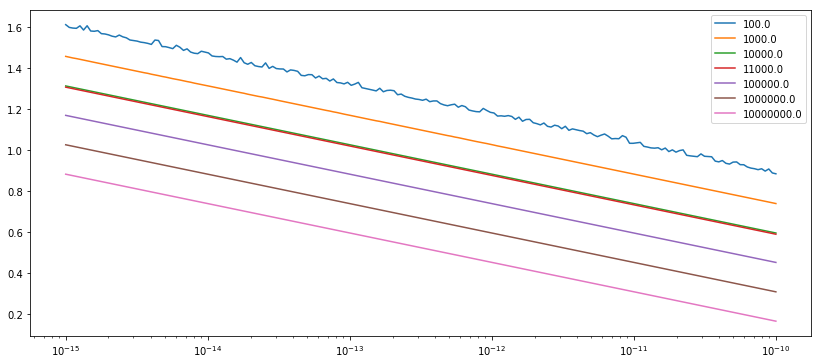

In [15]:
fig, ax = plt.subplots(figsize=(14, 6))
tols = np.logspace(-15, -10, 200)
for factor in [1e2, 1e3, 1e4, 1.1e4, 1e5, 1e6, 1e7]:
    plot_tss_conv(factor, tols, ax)
ax.legend()